In [10]:
pip install twstock


Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install pymssql


Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install requests pandas pyodbc beautifulsoup4 lxml


Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [14]:
import pyodbc
import logging
import sys

# 設定日誌
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.FileHandler(f"db_test.log", encoding='utf-8'), logging.StreamHandler()]
)
logger = logging.getLogger()

def test_connection(conn_string):
    """測試資料庫連接"""
    logger.info(f"嘗試連接資料庫...")
    try:
        conn = pyodbc.connect(conn_string)
        cursor = conn.cursor()
        logger.info("資料庫連接成功!")
        
        # 檢查驅動程式版本
        cursor.execute("SELECT @@version")
        version = cursor.fetchone()[0]
        logger.info(f"SQL Server 版本: {version}")
        
        # 列出所有資料庫
        logger.info("資料庫列表:")
        cursor.execute("SELECT name FROM sys.databases")
        for row in cursor.fetchall():
            logger.info(f" - {row[0]}")
        
        # 列出 StockDB 中的所有表格
        try:
            cursor.execute("USE StockDB")
            cursor.execute("SELECT TABLE_NAME FROM INFORMATION_SCHEMA.TABLES WHERE TABLE_TYPE = 'BASE TABLE'")
            logger.info("StockDB 中的表格:")
            tables = [row[0] for row in cursor.fetchall()]
            
            if 'StockBasicInfo' in tables:
                logger.info(" - StockBasicInfo (目標表格存在)")
                
                # 檢查表格結構
                cursor.execute("SELECT COLUMN_NAME, DATA_TYPE, CHARACTER_MAXIMUM_LENGTH FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = 'StockBasicInfo'")
                logger.info("StockBasicInfo 表格結構:")
                for col in cursor.fetchall():
                    logger.info(f" - {col[0]}: {col[1]}" + (f"({col[2]})" if col[2] else ""))
                
                # 檢查資料筆數
                cursor.execute("SELECT COUNT(*) FROM StockBasicInfo")
                count = cursor.fetchone()[0]
                logger.info(f"StockBasicInfo 資料筆數: {count}")
                
                # 檢查部分資料
                cursor.execute("SELECT TOP 5 代號, 名稱, 產業類別, 更新時間, 資料量 FROM StockBasicInfo")
                logger.info("StockBasicInfo 前5筆資料:")
                for row in cursor.fetchall():
                    logger.info(f" - {row[0]}, {row[1]}, {row[2]}, {row[3]}, {row[4]}")
            else:
                for t in tables:
                    logger.info(f" - {t}")
                logger.warning("StockBasicInfo 表格不存在!")
                
                # 創建表格
                logger.info("嘗試創建 StockBasicInfo 表格...")
                cursor.execute("""
                CREATE TABLE dbo.StockBasicInfo (
                    代號 VARCHAR(10) PRIMARY KEY,
                    名稱 NVARCHAR(50) NOT NULL,
                    產業類別 NVARCHAR(50) NULL,
                    更新時間 DATETIME DEFAULT GETDATE(),
                    資料量 INT DEFAULT 0
                )
                """)
                conn.commit()
                logger.info("成功創建 StockBasicInfo 表格!")
                
        except Exception as e:
            logger.error(f"查詢表格時出錯: {e}")
        
        # 測試插入和查詢
        try:
            if 'StockBasicInfo' in tables:
                # 插入測試數據
                logger.info("插入測試數據...")
                test_code = "TEST01"
                
                # 先刪除測試數據 (如果存在)
                cursor.execute("DELETE FROM StockBasicInfo WHERE 代號 = ?", test_code)
                
                # 插入新數據
                cursor.execute("""
                INSERT INTO StockBasicInfo (代號, 名稱, 產業類別, 更新時間, 資料量)
                VALUES (?, ?, ?, GETDATE(), ?)
                """, test_code, "測試股票", "測試產業", 100)
                conn.commit()
                
                # 查詢剛插入的數據
                cursor.execute("SELECT * FROM StockBasicInfo WHERE 代號 = ?", test_code)
                test_row = cursor.fetchone()
                if test_row:
                    logger.info(f"成功插入並查詢測試數據: {test_row}")
                else:
                    logger.warning("插入測試數據失敗!")
                
                # 刪除測試數據
                cursor.execute("DELETE FROM StockBasicInfo WHERE 代號 = ?", test_code)
                conn.commit()
                logger.info("刪除測試數據")
        except Exception as e:
            logger.error(f"測試數據操作時出錯: {e}")
        
        cursor.close()
        conn.close()
        return True
        
    except pyodbc.Error as e:
        logger.error(f"資料庫連接失敗: {e}")
        
        # 嘗試列出可用的驅動程式
        drivers = pyodbc.drivers()
        logger.info(f"系統中可用的 ODBC 驅動程式: {drivers}")
        
        return False

if __name__ == "__main__":
    conn_str = "Driver={SQL Server};Server=DESKTOP-TOB09L9;Database=StockDB;Trusted_Connection=yes;"
    
    if len(sys.argv) > 1:
        conn_str = sys.argv[1]
    
    logger.info(f"使用連接字串: {conn_str}")
    
    if test_connection(conn_str):
        logger.info("資料庫連線測試成功!")
    else:
        logger.error("資料庫連線測試失敗!")

2025-07-16 18:10:04,861 - INFO - 使用連接字串: --f=c:\Users\USER\AppData\Roaming\jupyter\runtime\kernel-v382c42c702f7f896a931e9594098e7e5fda737ead.json
2025-07-16 18:10:04,862 - INFO - 嘗試連接資料庫...
2025-07-16 18:10:04,864 - ERROR - 資料庫連接失敗: ('IM002', '[IM002] [Microsoft][ODBC 驅動程式管理員] 找不到資料來源名稱且未指定預設的驅動程式 (0) (SQLDriverConnect)')
2025-07-16 18:10:04,867 - INFO - 系統中可用的 ODBC 驅動程式: ['SQL Server', 'SQL Server Native Client RDA 11.0', 'ODBC Driver 17 for SQL Server', 'Microsoft Access Driver (*.mdb, *.accdb)', 'Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)', 'Microsoft Access Text Driver (*.txt, *.csv)', 'Microsoft Access dBASE Driver (*.dbf, *.ndx, *.mdx)']
2025-07-16 18:10:04,868 - ERROR - 資料庫連線測試失敗!


In [15]:
import pandas as pd
import os
import pyodbc
from datetime import datetime

# 設定 SQL Server 資料庫連線
conn = pyodbc.connect(
    'DRIVER={SQL Server};'
    'SERVER=DESKTOP-TOB09L9;'
    'DATABASE=stockDB;'  # 請替換為您實際的資料庫名稱
    'Trusted_Connection=yes;'
)
cursor = conn.cursor()

# 創建產業分類表
industry_table_name = "StockIndustry"

# 檢查產業分類表是否存在
check_table_sql = f"""
SELECT CASE WHEN OBJECT_ID(N'[dbo].[{industry_table_name}]', N'U') IS NULL 
       THEN 0 ELSE 1 END AS table_exists
"""

cursor.execute(check_table_sql)
table_exists = cursor.fetchone()[0]

if not table_exists:
    # 定義產業分類表
    create_table_sql = f"""
    CREATE TABLE [dbo].[{industry_table_name}] (
        [股票代碼] NVARCHAR(10) PRIMARY KEY,
        [股票名稱] NVARCHAR(100),
        [產業類別] NVARCHAR(50),
        [上市/上櫃] NVARCHAR(10),
        [更新日期] DATE
    )
    """
    
    cursor.execute(create_table_sql)
    conn.commit()
    print(f"成功創建產業分類表: {industry_table_name}")

# 定義產業分類對應 (這裡以簡化的版本為例，您可以根據實際需求擴展)
industry_mapping = {
    # 電子產業
    "2330": {"name": "台積電", "industry": "半導體", "listed": "上市"},
    "2454": {"name": "聯發科", "industry": "半導體", "listed": "上市"},
    "2317": {"name": "鴻海", "industry": "電子零組件", "listed": "上市"},
    "2308": {"name": "台達電", "industry": "電子零組件", "listed": "上市"},
    
    # 金融產業
    "2882": {"name": "國泰金", "industry": "金融保險", "listed": "上市"},
    "2881": {"name": "富邦金", "industry": "金融保險", "listed": "上市"},
    "2884": {"name": "玉山金", "industry": "金融保險", "listed": "上市"},
    
    # 傳統產業
    "1301": {"name": "台塑", "industry": "塑膠", "listed": "上市"},
    "1326": {"name": "台化", "industry": "塑膠", "listed": "上市"},
    "2002": {"name": "中鋼", "industry": "鋼鐵", "listed": "上市"},
    
    # 其他產業
    "2412": {"name": "中華電", "industry": "電信服務", "listed": "上市"},
    "9910": {"name": "豐泰", "industry": "運動鞋", "listed": "上市"},
    "3711": {"name": "日月光投控", "industry": "半導體", "listed": "上市"},
    
    # 上櫃公司
    "6488": {"name": "環球晶", "industry": "半導體", "listed": "上櫃"},
    "3105": {"name": "穩懋", "industry": "半導體", "listed": "上櫃"},
    "4966": {"name": "譜瑞-KY", "industry": "半導體", "listed": "上櫃"},
    "6510": {"name": "精測", "industry": "電子零組件", "listed": "上櫃"}
}

# 插入或更新產業分類資料
update_date = datetime.now().strftime("%Y-%m-%d")

for stock_code, info in industry_mapping.items():
    # 檢查是否已存在該股票
    check_stock_sql = f"""
    SELECT COUNT(*) FROM [dbo].[{industry_table_name}]
    WHERE [股票代碼] = ?
    """
    
    cursor.execute(check_stock_sql, stock_code)
    exists = cursor.fetchone()[0]
    
    if exists:
        # 更新股票資訊
        update_sql = f"""
        UPDATE [dbo].[{industry_table_name}]
        SET [股票名稱] = ?,
            [產業類別] = ?,
            [上市/上櫃] = ?,
            [更新日期] = ?
        WHERE [股票代碼] = ?
        """
        
        cursor.execute(update_sql, 
                       info["name"], 
                       info["industry"], 
                       info["listed"], 
                       update_date, 
                       stock_code)
    else:
        # 插入新股票
        insert_sql = f"""
        INSERT INTO [dbo].[{industry_table_name}]
        ([股票代碼], [股票名稱], [產業類別], [上市/上櫃], [更新日期])
        VALUES (?, ?, ?, ?, ?)
        """
        
        cursor.execute(insert_sql, 
                       stock_code, 
                       info["name"], 
                       info["industry"], 
                       info["listed"], 
                       update_date)

conn.commit()
print(f"成功更新產業分類資料")

# 顯示按產業分類的統計資料
stats_sql = f"""
SELECT [產業類別], COUNT(*) AS 股票數量, [上市/上櫃]
FROM [dbo].[{industry_table_name}]
GROUP BY [產業類別], [上市/上櫃]
ORDER BY [產業類別], [上市/上櫃]
"""

cursor.execute(stats_sql)
results = cursor.fetchall()

print("\n按產業分類的統計資料:")
print("產業類別\t上市/上櫃\t股票數量")
print("-" * 40)
for row in results:
    print(f"{row[0]}\t{row[2]}\t{row[1]}")

# 關閉連線
cursor.close()
conn.close()

成功更新產業分類資料

按產業分類的統計資料:
產業類別	上市/上櫃	股票數量
----------------------------------------
半導體	上市	3
半導體	上櫃	3
金融保險	上市	3
塑膠	上市	2
運動鞋	上市	1
電子零組件	上市	2
電子零組件	上櫃	1
電信服務	上市	1
鋼鐵	上市	1


In [16]:
import pyodbc
import pandas as pd
import os

# 設定 SQL Server 資料庫連線
conn = pyodbc.connect(
    'DRIVER={SQL Server};'
    'SERVER=DESKTOP-TOB09L9;'
    'DATABASE=stockDB;'  # 請替換為您實際的資料庫名稱
    'Trusted_Connection=yes;'
)
cursor = conn.cursor()

# 獲取所有股票表格名稱
table_list_sql = """
SELECT TABLE_NAME 
FROM INFORMATION_SCHEMA.TABLES 
WHERE TABLE_TYPE = 'BASE TABLE' 
AND TABLE_CATALOG = DB_NAME()
"""

cursor.execute(table_list_sql)
tables = [row[0] for row in cursor.fetchall()]
print(f"資料庫中共有 {len(tables)} 個表格")

# 篩選出可能是股票資料表的表名（假設表名為股票代碼）
stock_tables = [table for table in tables if table.replace('TW', '').isdigit()]
print(f"篩選出 {len(stock_tables)} 個可能是股票的表格")
print(f"前5個股票表格: {stock_tables[:5] if len(stock_tables) >= 5 else stock_tables}")

# 定義產業分類對應
industry_mapping = {
    # 半導體產業
    "2330": "半導體", "2454": "半導體", "2379": "半導體", "3034": "半導體", "2337": "半導體", 
    "2303": "半導體", "2329": "半導體", "2308": "半導體", "2344": "半導體", "2382": "半導體",
    
    # 電子零件
    "2317": "電子零件", "2354": "電子零件", "2421": "電子零件", "2474": "電子零件", 
    
    # 光電
    "2409": "光電", "3481": "光電", "2387": "光電", "3532": "光電", "3026": "光電",
    
    # 通訊網路
    "2412": "通訊網路", "2353": "通訊網路", "2498": "通訊網路", "3045": "通訊網路",
    
    # 電腦及周邊
    "2357": "電腦及周邊", "2376": "電腦及周邊", "2345": "電腦及周邊", "2324": "電腦及周邊",
    
    # 金融保險
    "2882": "金融保險", "2881": "金融保險", "2884": "金融保險", "2883": "金融保險", "2891": "金融保險",
    "2886": "金融保險", "2885": "金融保險", "2887": "金融保險", "2889": "金融保險", "2888": "金融保險",
    
    # 傳產類
    "1301": "塑膠", "1326": "塑膠", "1303": "塑膠",
    "2002": "鋼鐵", "2006": "鋼鐵", "2007": "鋼鐵",
    "2301": "電子", "2409": "電子",
    
    # ETF類
    "0050": "ETF", "0056": "ETF", "0057": "ETF", "006208": "ETF", "00878": "ETF",
    "00929": "ETF", "00713": "ETF", "00896": "ETF", "00881": "ETF", "00891": "ETF",
    
    # 其他
    "9945": "傳產", "9904": "傳產", "9914": "傳產", "9917": "傳產", "9925": "傳產",
    "2912": "傳產", "2915": "傳產", "1605": "傳產", "1590": "傳產", "1504": "傳產"
}

# 創建一個資料框來保存結果
results = []

for table in stock_tables:
    # 提取股票代碼
    stock_code = table.replace('TW', '')
    
    # 如果有產業分類資訊，則記錄
    industry = industry_mapping.get(stock_code, "未分類")
    
    # 獲取該股票的一些基本資訊
    try:
        # 先檢查表結構
        cursor.execute(f"SELECT TOP 0 * FROM [{table}]")
        columns = [column[0] for column in cursor.description]
        
        # 檢查是否有基本欄位
        date_col = next((col for col in columns if col.lower() in ['date', 'trading_date', '日期']), None)
        close_col = next((col for col in columns if col.lower() in ['close', 'closing_price', '收盤價']), None)
        
        if date_col and close_col:
            # 獲取最新收盤價
            cursor.execute(f"""
                SELECT TOP 1 [{date_col}], [{close_col}] 
                FROM [{table}] 
                ORDER BY [{date_col}] DESC
            """)
            row = cursor.fetchone()
            if row:
                last_date, last_close = row
            else:
                last_date, last_close = None, None
        else:
            last_date, last_close = None, None
            
        results.append({
            "股票代碼": stock_code,
            "資料表名": table,
            "產業類別": industry,
            "最新日期": last_date,
            "最新收盤價": last_close
        })
    except Exception as e:
        print(f"查詢表 {table} 時出錯: {e}")

print(f"成功處理 {len(results)} 個股票資料表")

# 檢查結果是否有資料
if not results:
    print("警告: 沒有收集到任何股票資料")
else:
    # 創建產業分類結果表
    df = pd.DataFrame(results)
    print(f"資料框中的欄位: {df.columns.tolist()}")
    
    # 輸出前幾行資料，檢查欄位
    print("\n前幾行資料:")
    print(df.head())
    
    # 按產業分組並計數
    if '產業類別' in df.columns:
        industry_counts = df.groupby("產業類別").size().reset_index(name='股票數量')
        
        # 輸出結果
        print("\n各產業股票數量統計:")
        print(industry_counts)
        
        # 使用原生 SQL 將結果保存到數據庫
        try:
            print("嘗試將結果保存到資料庫...")
            
            # 首先，刪除表格（如果存在）
            cursor.execute("""
                IF OBJECT_ID('StockIndustryClassification', 'U') IS NOT NULL
                    DROP TABLE StockIndustryClassification
            """)
            conn.commit()
            
            # 創建新表格
            cursor.execute("""
                CREATE TABLE StockIndustryClassification (
                    股票代碼 NVARCHAR(20),
                    資料表名 NVARCHAR(100),
                    產業類別 NVARCHAR(50),
                    最新日期 DATE,
                    最新收盤價 FLOAT
                )
            """)
            conn.commit()
            
            # 插入數據
            for index, row in df.iterrows():
                cursor.execute("""
                    INSERT INTO StockIndustryClassification (股票代碼, 資料表名, 產業類別, 最新日期, 最新收盤價)
                    VALUES (?, ?, ?, ?, ?)
                """, row['股票代碼'], row['資料表名'], row['產業類別'], 
                    row['最新日期'] if pd.notna(row['最新日期']) else None, 
                    row['最新收盤價'] if pd.notna(row['最新收盤價']) else None)
            conn.commit()
            
            # 同樣操作產業統計表
            cursor.execute("""
                IF OBJECT_ID('IndustrySummary', 'U') IS NOT NULL
                    DROP TABLE IndustrySummary
            """)
            conn.commit()
            
            cursor.execute("""
                CREATE TABLE IndustrySummary (
                    產業類別 NVARCHAR(50),
                    股票數量 INT
                )
            """)
            conn.commit()
            
            for index, row in industry_counts.iterrows():
                cursor.execute("""
                    INSERT INTO IndustrySummary (產業類別, 股票數量)
                    VALUES (?, ?)
                """, row['產業類別'], row['股票數量'])
            conn.commit()
            
            print("成功保存結果到資料庫")
        except Exception as e:
            print(f"保存到資料庫時出錯: {e}")
            print("改為保存到 CSV 文件...")
            csv_path = "StockIndustryClassification.csv"
            df.to_csv(csv_path, index=False, encoding='utf-8-sig')
            industry_counts.to_csv("IndustrySummary.csv", index=False, encoding='utf-8-sig')
            print(f"已保存到 CSV 文件: {csv_path}")
            
        # 保存一份產業分類的HTML報表
        try:
            html_path = "產業分類報表.html"
            with open(html_path, 'w', encoding='utf-8') as f:
                f.write("""
                <html>
                <head>
                    <title>股票產業分類報表</title>
                    <meta charset="utf-8">
                    <style>
                        body { font-family: Arial, sans-serif; margin: 20px; }
                        h1 { color: #333; }
                        table { border-collapse: collapse; width: 100%; margin-top: 20px; }
                        th, td { border: 1px solid #ddd; padding: 8px; text-align: left; }
                        th { background-color: #f2f2f2; }
                        tr:nth-child(even) { background-color: #f9f9f9; }
                        .industry-section { margin-top: 30px; }
                        .summary { margin-top: 30px; }
                    </style>
                </head>
                <body>
                    <h1>股票產業分類報表</h1>
                    
                    <div class="summary">
                        <h2>產業統計摘要</h2>
                        <table>
                            <tr>
                                <th>產業類別</th>
                                <th>股票數量</th>
                            </tr>
                """)
                
                # 添加產業統計
                for index, row in industry_counts.iterrows():
                    f.write(f"""
                            <tr>
                                <td>{row['產業類別']}</td>
                                <td>{row['股票數量']}</td>
                            </tr>
                    """)
                
                f.write("""
                        </table>
                    </div>
                """)
                
                # 按產業分組顯示股票
                for industry in industry_counts['產業類別']:
                    industry_stocks = df[df['產業類別'] == industry]
                    f.write(f"""
                    <div class="industry-section">
                        <h2>{industry}</h2>
                        <table>
                            <tr>
                                <th>股票代碼</th>
                                <th>資料表名</th>
                                <th>最新日期</th>
                                <th>最新收盤價</th>
                            </tr>
                    """)
                    
                    for index, row in industry_stocks.iterrows():
                        f.write(f"""
                            <tr>
                                <td>{row['股票代碼']}</td>
                                <td>{row['資料表名']}</td>
                                <td>{row['最新日期'] if pd.notna(row['最新日期']) else ''}</td>
                                <td>{row['最新收盤價'] if pd.notna(row['最新收盤價']) else ''}</td>
                            </tr>
                        """)
                    
                    f.write("""
                        </table>
                    </div>
                    """)
                
                f.write("""
                </body>
                </html>
                """)
            
            print(f"已生成HTML報表: {html_path}")
        except Exception as e:
            print(f"生成HTML報表時出錯: {e}")
    else:
        print(f"錯誤: 資料框中沒有 '產業類別' 欄位")

# 關閉連線
cursor.close()
conn.close()

資料庫中共有 1330 個表格
篩選出 122 個可能是股票的表格
前5個股票表格: ['00661TW', '00971TW', '00662TW', '00668TW', '00678TW']
成功處理 122 個股票資料表
資料框中的欄位: ['股票代碼', '資料表名', '產業類別', '最新日期', '最新收盤價']

前幾行資料:
    股票代碼     資料表名 產業類別  最新日期 最新收盤價
0  00661  00661TW  未分類  None  None
1  00971  00971TW  未分類  None  None
2  00662  00662TW  未分類  None  None
3  00668  00668TW  未分類  None  None
4  00678  00678TW  未分類  None  None

各產業股票數量統計:
  產業類別  股票數量
0  ETF    10
1  未分類   112
嘗試將結果保存到資料庫...
成功保存結果到資料庫
已生成HTML報表: 產業分類報表.html


開始優化交易策略參數...


第 1 代 / 共 20 代，最佳適應度: 0.1989，最佳參數: TradingParams(sma_short=11, sma_long=20, std_period=25, alpha=0.14767793585602607)
第 5 代 / 共 20 代，最佳適應度: 0.1989，最佳參數: TradingParams(sma_short=9, sma_long=20, std_period=23, alpha=0.16474582636781918)
第 10 代 / 共 20 代，最佳適應度: 0.2276，最佳參數: TradingParams(sma_short=10, sma_long=18, std_period=24, alpha=0.14767793585602607)
第 15 代 / 共 20 代，最佳適應度: 0.2276，最佳參數: TradingParams(sma_short=10, sma_long=18, std_period=24, alpha=0.14767793585602607)
第 20 代 / 共 20 代，最佳適應度: 0.2276，最佳參數: TradingParams(sma_short=10, sma_long=18, std_period=24, alpha=0.14767793585602607)

最佳參數:
短期移動平均: 10
長期移動平均: 18
標準差期間: 24
波動率調整係數: 0.1477

回測結果:
總報酬率: 14.79%
勝率: 66.67%
最大回撤: 3.29%
夏普比率: 0.4500
交易次數: 12

回測結果圖表已保存為 'backtest_results.png'
適應度歷史圖表已保存為 'fitness_history.png'


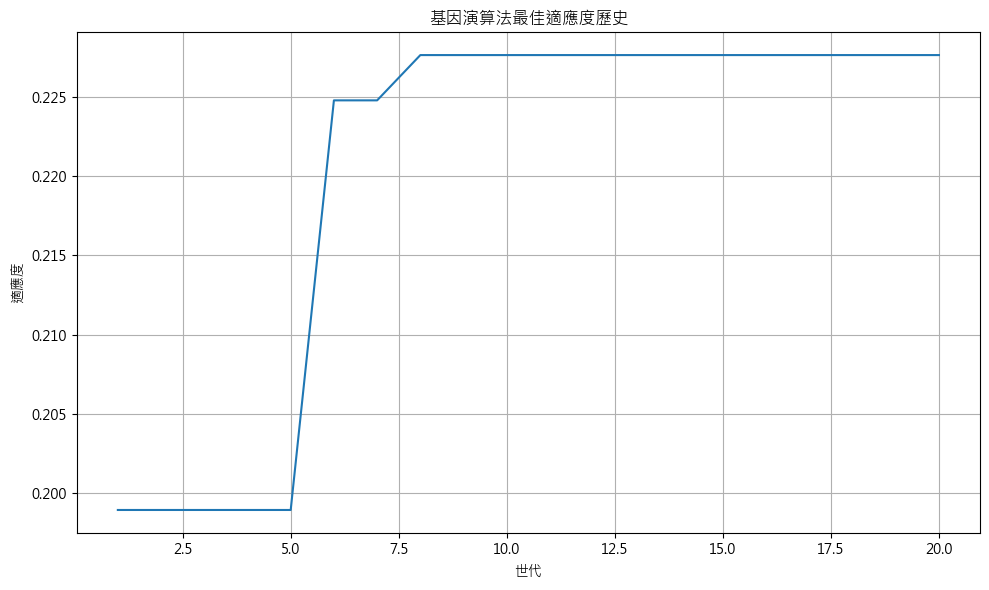

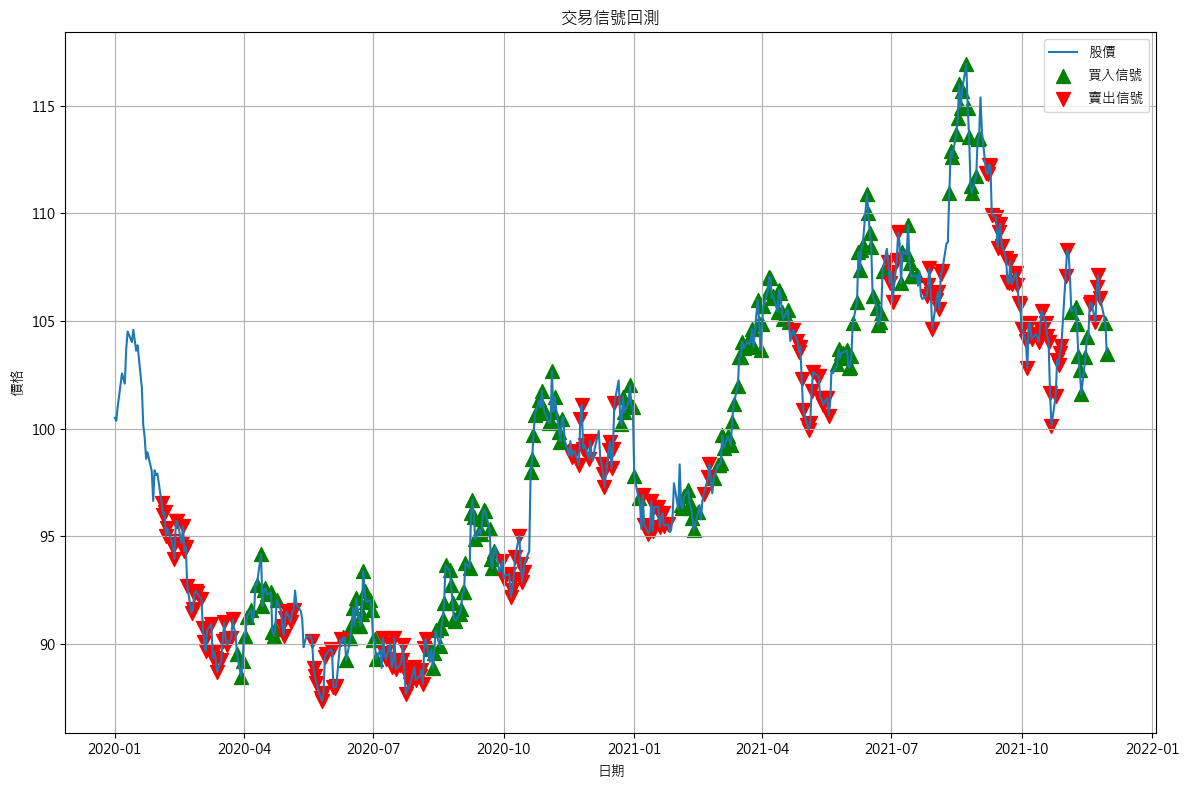

In [17]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from dataclasses import dataclass

@dataclass
class TradingParams:
    """交易策略參數"""
    sma_short: int       # 短期移動平均線天數
    sma_long: int        # 長期移動平均線天數
    std_period: int      # 標準差計算期間
    alpha: float         # 波動率調整係數
    
    @classmethod
    def create_random(cls):
        """建立隨機參數"""
        return cls(
            sma_short=random.randint(3, 15),
            sma_long=random.randint(20, 60),
            std_period=random.randint(10, 30),
            alpha=random.uniform(0.1, 0.5)
        )
    
    def mutate(self, mutation_rate: float = 0.2, mutation_scale: float = 0.2):
        """參數變異"""
        if random.random() < mutation_rate:
            self.sma_short = max(2, int(self.sma_short * (1 + random.uniform(-mutation_scale, mutation_scale))))
        if random.random() < mutation_rate:
            self.sma_long = max(self.sma_short + 5, int(self.sma_long * (1 + random.uniform(-mutation_scale, mutation_scale))))
        if random.random() < mutation_rate:
            self.std_period = max(5, int(self.std_period * (1 + random.uniform(-mutation_scale, mutation_scale))))
        if random.random() < mutation_rate:
            self.alpha = max(0.05, min(1.0, self.alpha * (1 + random.uniform(-mutation_scale, mutation_scale))))


class TradingSystem:
    """交易系統"""
    def __init__(self, params: TradingParams):
        self.params = params
    
    def calculate_indicators(self, data: pd.DataFrame) -> Tuple[pd.Series, pd.Series, pd.Series]:
        """計算技術指標"""
        close_prices = data['Close']
        
        # 計算移動平均
        ma_short = close_prices.rolling(window=self.params.sma_short).mean()
        ma_long = close_prices.rolling(window=self.params.sma_long).mean()
        
        # 計算標準差
        std = close_prices.rolling(window=self.params.std_period).std()
        
        return ma_short, ma_long, std
    
    def generate_signals(self, data: pd.DataFrame) -> pd.Series:
        """生成交易信號"""
        ma_short, ma_long, std = self.calculate_indicators(data)
        close_prices = data['Close']
        
        signals = pd.Series(0, index=data.index)
        
        # 生成買賣信號
        for i in range(len(data)):
            if pd.notna(ma_short.iloc[i]) and pd.notna(ma_long.iloc[i]) and pd.notna(std.iloc[i]):
                # 買入條件: 短期均線上穿長期均線，且考慮波動度
                if (ma_short.iloc[i] > ma_long.iloc[i] * 
                    (1 + self.params.alpha * std.iloc[i] / close_prices.iloc[i])):
                    signals.iloc[i] = 1  # 買入信號
                # 賣出kondtion: 短期均線下穿長期均線，且考慮波動度
                elif (ma_short.iloc[i] < ma_long.iloc[i] * 
                     (1 - self.params.alpha * std.iloc[i] / close_prices.iloc[i])):
                    signals.iloc[i] = -1  # 賣出信號
        
        return signals
    
    def backtest(self, data: pd.DataFrame) -> Dict[str, float]:
        """回測策略並計算績效指標"""
        signals = self.generate_signals(data)
        
        # 初始化
        position = 0  # 目前持倉狀態: 0 表示無持倉, 1 表示做多
        trades = []   # 儲存所有交易記錄
        
        # 進行模擬交易
        for i in range(len(data)):
            # 若無持倉且有買入信號
            if position == 0 and signals.iloc[i] == 1:
                position = 1
                trades.append({
                    'entry_date': data.index[i],
                    'entry_price': data['Close'].iloc[i],
                    'exit_date': None,
                    'exit_price': None
                })
            # 若持有多頭且有賣出信號
            elif position == 1 and signals.iloc[i] == -1:
                position = 0
                trades[-1]['exit_date'] = data.index[i]
                trades[-1]['exit_price'] = data['Close'].iloc[i]
        
        # 若最後還有未平倉的交易，以最後價格平倉
        if trades and trades[-1]['exit_date'] is None:
            trades[-1]['exit_date'] = data.index[-1]
            trades[-1]['exit_price'] = data['Close'].iloc[-1]
        
        # 若無交易，直接返回零績效
        if not trades:
            return {
                'total_return': 0,
                'win_rate': 0,
                'max_drawdown': 0,
                'sharpe_ratio': 0,
                'trades_count': 0
            }
        
        # 計算每筆交易的報酬率
        returns = [(t['exit_price'] / t['entry_price'] - 1) for t in trades if t['exit_price'] is not None]
        
        # 計算績效指標
        total_return = sum(returns)
        win_rate = sum(1 for r in returns if r > 0) / len(returns)
        
        # 計算資金曲線和最大回撤
        equity_curve = [1.0]
        for r in returns:
            equity_curve.append(equity_curve[-1] * (1 + r))
        
        # 計算最大回撤
        max_drawdown = 0
        peak = equity_curve[0]
        
        for value in equity_curve:
            if value > peak:
                peak = value
            drawdown = (peak - value) / peak
            max_drawdown = max(max_drawdown, drawdown)
        
        # 計算夏普比率 (假設無風險利率為0)
        if len(returns) > 1:
            sharpe_ratio = np.mean(returns) / np.std(returns) if np.std(returns) > 0 else 0
        else:
            sharpe_ratio = 0
        
        return {
            'total_return': total_return,
            'win_rate': win_rate,
            'max_drawdown': max_drawdown,
            'sharpe_ratio': sharpe_ratio,
            'trades_count': len(trades)
        }


class GeneticAlgorithm:
    """基因演算法優化器"""
    def __init__(self, 
                 population_size: int = 50,
                 generations: int = 30,
                 crossover_rate: float = 0.8,
                 mutation_rate: float = 0.2,
                 elite_size: int = 5):
        self.population_size = population_size
        self.generations = generations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.elite_size = elite_size
    
    def initialize_population(self) -> List[TradingParams]:
        """初始化種群"""
        return [TradingParams.create_random() for _ in range(self.population_size)]
    
    def evaluate_fitness(self, individual: TradingParams, data: pd.DataFrame) -> float:
        """評估個體適應度"""
        trading_system = TradingSystem(individual)
        results = trading_system.backtest(data)
        
        # 適應度函數 - 根據多項指標計算綜合分數
        fitness = (
            results['total_return'] * 0.4 +  # 總報酬率權重 40%
            results['win_rate'] * 0.2 +       # 勝率權重 20%
            -abs(results['max_drawdown']) * 0.3 +  # 最大回撤權重 30%
            results['sharpe_ratio'] * 0.1      # 夏普比率權重 10%
        )
        
        return fitness
    
    def selection(self, population: List[TradingParams], fitness_scores: List[float]) -> List[TradingParams]:
        """選擇操作 - 輪盤賭選擇"""
        # 處理負適應度
        adjusted_scores = [f - min(fitness_scores) + 1e-6 for f in fitness_scores]
        total_fitness = sum(adjusted_scores)
        
        # 計算選擇概率
        selection_probs = [f / total_fitness for f in adjusted_scores]
        
        # 保留精英
        indices = np.argsort(fitness_scores)[-self.elite_size:]
        selected = [population[i] for i in indices]
        
        # 輪盤賭選擇
        while len(selected) < self.population_size:
            idx = np.random.choice(len(population), p=selection_probs)
            selected.append(population[idx])
        
        return selected
    
    def crossover(self, parent1: TradingParams, parent2: TradingParams) -> Tuple[TradingParams, TradingParams]:
        """交叉操作"""
        if random.random() > self.crossover_rate:
            return parent1, parent2
        
        # 單點交叉
        child1 = TradingParams(
            sma_short=parent1.sma_short,
            sma_long=parent2.sma_long,
            std_period=parent1.std_period,
            alpha=parent2.alpha
        )
        
        child2 = TradingParams(
            sma_short=parent2.sma_short,
            sma_long=parent1.sma_long,
            std_period=parent2.std_period,
            alpha=parent1.alpha
        )
        
        return child1, child2
    
    def mutation(self, individual: TradingParams) -> TradingParams:
        """變異操作"""
        individual.mutate(self.mutation_rate)
        return individual
    
    def create_next_generation(self, population: List[TradingParams], fitness_scores: List[float]) -> List[TradingParams]:
        """創建下一代"""
        # 選擇
        selected = self.selection(population, fitness_scores)
        
        # 交叉和變異
        next_gen = []
        
        # 保留精英
        elite_indices = np.argsort(fitness_scores)[-self.elite_size:]
        for i in elite_indices:
            next_gen.append(population[i])
        
        # 生成剩餘個體
        while len(next_gen) < self.population_size:
            parent1, parent2 = random.sample(selected, 2)
            child1, child2 = self.crossover(parent1, parent2)
            
            child1 = self.mutation(child1)
            child2 = self.mutation(child2)
            
            next_gen.append(child1)
            if len(next_gen) < self.population_size:
                next_gen.append(child2)
        
        return next_gen
    
    def optimize(self, data: pd.DataFrame) -> Tuple[TradingParams, Dict[str, float]]:
        """執行優化"""
        # 初始化種群
        population = self.initialize_population()
        best_individual = None
        best_fitness = float('-inf')
        best_results = None
        
        # 記錄每代的最佳適應度
        fitness_history = []
        
        # 進化過程
        for generation in range(self.generations):
            # 評估適應度
            fitness_scores = []
            for individual in population:
                trading_system = TradingSystem(individual)
                results = trading_system.backtest(data)
                
                # 計算適應度
                fitness = (
                    results['total_return'] * 0.4 +
                    results['win_rate'] * 0.2 +
                    -abs(results['max_drawdown']) * 0.3 +
                    results['sharpe_ratio'] * 0.1
                )
                
                fitness_scores.append(fitness)
                
                # 更新最佳個體
                if fitness > best_fitness:
                    best_fitness = fitness
                    best_individual = individual
                    best_results = results
            
            # 記錄本代最佳適應度
            fitness_history.append(max(fitness_scores))
            
            # 輸出進度
            if (generation + 1) % 5 == 0 or generation == 0:
                print(f"第 {generation + 1} 代 / 共 {self.generations} 代，"
                      f"最佳適應度: {best_fitness:.4f}，"
                      f"最佳參數: {best_individual}")
            
            # 創建下一代
            if generation < self.generations - 1:
                population = self.create_next_generation(population, fitness_scores)
        
        # 使用最佳參數進行最後評估
        trading_system = TradingSystem(best_individual)
        final_results = trading_system.backtest(data)
        
        # 繪製適應度歷史圖表
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, self.generations + 1), fitness_history)
        plt.title('基因演算法最佳適應度歷史')
        plt.xlabel('世代')
        plt.ylabel('適應度')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('fitness_history.png')
        
        return best_individual, final_results
    
    def plot_backtest_results(self, params: TradingParams, data: pd.DataFrame):
        """繪製回測結果"""
        trading_system = TradingSystem(params)
        signals = trading_system.generate_signals(data)
        
        # 買入和賣出點
        buy_signals = data[signals == 1]
        sell_signals = data[signals == -1]
        
        plt.figure(figsize=(12, 8))
        plt.plot(data.index, data['Close'], label='股價')
        plt.scatter(buy_signals.index, buy_signals['Close'], color='green', 
                   marker='^', s=100, label='買入信號')
        plt.scatter(sell_signals.index, sell_signals['Close'], color='red', 
                   marker='v', s=100, label='賣出信號')
        
        plt.title('交易信號回測')
        plt.xlabel('日期')
        plt.ylabel('價格')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('backtest_results.png')


# 示範如何使用
def demonstrate_usage():
    """示範如何使用基因演算法優化交易策略"""
    # 假設我們有一組股價數據 (真實情況下應該從文件或API獲取)
    # 這裡隨機生成一些模擬數據
    np.random.seed(42)
    dates = pd.date_range(start='2020-01-01', periods=500, freq='B')
    
    # 生成隨機價格
    prices = np.random.normal(loc=0, scale=0.01, size=len(dates)).cumsum()
    prices = 100 * np.exp(prices)  # 轉換為更實際的股價
    
    # 創建DataFrame
    data = pd.DataFrame({
        'Open': prices * np.random.uniform(0.99, 1.00, len(prices)),
        'High': prices * np.random.uniform(1.01, 1.03, len(prices)),
        'Low': prices * np.random.uniform(0.97, 0.99, len(prices)),
        'Close': prices,
        'Volume': np.random.randint(1000000, 10000000, len(prices))
    }, index=dates)
    
    # 初始化基因演算法
    ga = GeneticAlgorithm(
        population_size=30,
        generations=20,
        crossover_rate=0.8,
        mutation_rate=0.2,
        elite_size=3
    )
    
    # 執行優化
    print("開始優化交易策略參數...")
    best_params, results = ga.optimize(data)
    
    # 輸出最終結果
    print("\n最佳參數:")
    print(f"短期移動平均: {best_params.sma_short}")
    print(f"長期移動平均: {best_params.sma_long}")
    print(f"標準差期間: {best_params.std_period}")
    print(f"波動率調整係數: {best_params.alpha:.4f}")
    
    print("\n回測結果:")
    print(f"總報酬率: {results['total_return']:.2%}")
    print(f"勝率: {results['win_rate']:.2%}")
    print(f"最大回撤: {results['max_drawdown']:.2%}")
    print(f"夏普比率: {results['sharpe_ratio']:.4f}")
    print(f"交易次數: {results['trades_count']}")
    
    # 繪製回測結果
    ga.plot_backtest_results(best_params, data)
    print("\n回測結果圖表已保存為 'backtest_results.png'")
    print("適應度歷史圖表已保存為 'fitness_history.png'")


if __name__ == "__main__":
    demonstrate_usage()

In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']  # 或 'SimHei', 'Noto Sans CJK TC'
plt.rcParams['axes.unicode_minus'] = False  # 正確顯示負號